### Team Project ISYE6740
### Bohao Cheng

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import warnings

InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")

average length of comment for train_df: 394.073


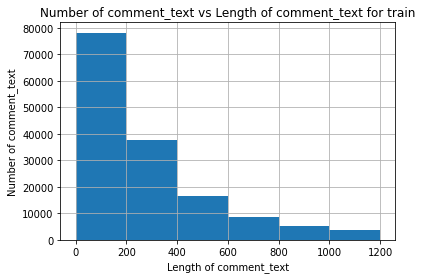

average length of comment for test_df: 364.875


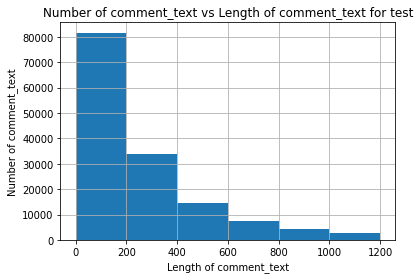

Wall time: 7.12 s


In [2]:
%%time
import datatable as dt
import matplotlib.pyplot as plt
import numpy as np

random_state = 42
train_dt = dt.fread("kaggle_toxic_comments_data/train.csv")
train_df = train_dt.to_pandas()
label_cols = [col for col in list(train_df.columns) if col not in ('id', 'comment_text')]
train_df[label_cols] = train_df[label_cols].astype(int)

test_dt = dt.fread("kaggle_toxic_comments_data/test.csv")
test_labels_dt = dt.fread("kaggle_toxic_comments_data/test_labels.csv")
test_dt.key = 'id'
test_labels_dt.key = 'id'
test_dt = test_dt[:,:, dt.join(test_labels_dt)]
test_df = test_dt.to_pandas()
test_df[label_cols] = test_df[label_cols].abs()

def plot_comment_text_distr(df, bins, dataset_name):
    comment_text_lengths = df['comment_text'].str.len()
    print(f'average length of comment for {dataset_name}_df: {np.mean(comment_text_lengths):.3f}' )
    plt.hist(comment_text_lengths, bins=bins)
    plt.xlabel('Length of comment_text')
    plt.ylabel('Number of comment_text')
    plt.title(f'Number of comment_text vs Length of comment_text for {dataset_name}')       
    plt.grid()
    plt.show()
plot_comment_text_distr(train_df, np.arange(0,1201,200), 'train')
plot_comment_text_distr(test_df, np.arange(0,1201,200), 'test')

average length of comment for train_df: 159.802


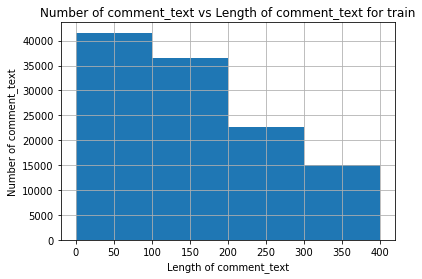

average length of comment for test_df: 148.967


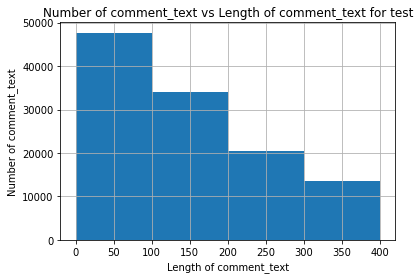

In [3]:
# adding filter to remove excessively long comments from model
train_mask = (train_df['comment_text'].str.len() <= 400)
train_df = train_df.loc[train_mask]
test_mask = (test_df['comment_text'].str.len() <= 400)
test_df = test_df.loc[test_mask]
plot_comment_text_distr(train_df, np.arange(0,401,100), 'train')
plot_comment_text_distr(test_df, np.arange(0,401,100), 'test')

In [4]:
from pandas_profiling import ProfileReport

generate_pd_prof = False
output_in_cell = False

if generate_pd_prof:
    prof = ProfileReport(train_df)
    if output_in_cell:
        prof.to_notebook_iframe()
    else:
        prof.to_file(output_file='pandas_profile_report.html')

In [5]:
import pandas as pd

nan_counts = train_df.isna().sum()
nan_counts_df = pd.DataFrame({'column_name':nan_counts.index, 'nan_count':nan_counts.values})
nan_counts_df
label_counts = train_df[label_cols].apply(pd.Series.value_counts)
label_counts

,column_name,nan_count
0,id,0
1,comment_text,0
2,toxic,0
3,severe_toxic,0
4,obscene,0
5,threat,0
6,insult,0
7,identity_hate,0


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,103037,114553,108680,115497,109128,114729
1,12873,1357,7230,413,6782,1181


In [6]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [7]:
%%time

comment_text_stored = False

if comment_text_stored:
    train_df = dt.fread('comment_text_store/result_df.csv')
    train_df = train_dt.to_pandas()
else:
    train_df['comment_text'] = train_df['comment_text'].map(lambda words : clean_text(words))
    train_df.to_csv('comment_text_store/result_df.csv')
    comment_text_stored = True

Wall time: 7.56 s


In [21]:
for label in label_cols:
    train_numer = len(train_df[label][train_df[label] == 1])
    train_denom = len(train_df[label][train_df[label] == 0])
    test_numer = len(test_df[label][test_df[label] == 1])
    test_denom = len(test_df[label][test_df[label] == 0])
    print(f'train ratio of {label} to not is: {train_numer}/{train_denom} = {train_numer/train_denom:.4f}')
    print(f'test ratio of {label} to not is: {test_numer}/{test_denom} = {test_numer/test_denom:.4f}\n')
print(f'overall train_df row count: {train_df.shape[0]}')
print(f'overall test_df row count: {test_df.shape[0]}')
print(f'train_size in train_test_split from this kaggle dataset is: {train_df.shape[0]/(test_df.shape[0]+train_df.shape[0]):.4f}')

train ratio of toxic to not is: 12873/103037 = 0.1249
test ratio of toxic to not is: 74029/41740 = 1.7736

train ratio of severe_toxic to not is: 1357/114553 = 0.0118
test ratio of severe_toxic to not is: 68854/46915 = 1.4676

train ratio of obscene to not is: 7230/108680 = 0.0665
test ratio of obscene to not is: 71870/43899 = 1.6372

train ratio of threat to not is: 413/115497 = 0.0036
test ratio of threat to not is: 68767/47002 = 1.4631

train ratio of insult to not is: 6782/109128 = 0.0621
test ratio of insult to not is: 71640/44129 = 1.6234

train ratio of identity_hate to not is: 1181/114729 = 0.0103
test ratio of identity_hate to not is: 69197/46572 = 1.4858

overall train_df row count: 115910
overall test_df row count: 115769
train_size in train_test_split from this kaggle dataset is: 0.5003


$TF$ is Term Frequency and $IDF$ is Inverse Document Frequency<br />
<br />
<br />
$TF(i,j) = \dfrac{term\ i\ frequency\ in\ document\ j}{total\ words\ in\ document\ j}$<br />
<br />
<br />
$IDF(j) = \log(\dfrac{total\ documents}{documents\ with\ term\ i})$<br />
<br />
<br />
CountVectorizer = $TF(i,j)$<br />
<br />
<br />
TfidfVectorizer = $TF(i,j) \cdot IDF(j)$

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import VotingClassifier
from sklearn import set_config
from sklearn.utils import estimator_html_repr
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
import joblib
import numpy as np
from nltk.corpus import stopwords
import string
import math
import glob

stop_words = set(stopwords.words('english') + list(string.punctuation.replace('\\', '')+ "0123456789"))
np.random.seed(random_state)
max_features = None
vect_dict = {
    'Tfidf': TfidfVectorizer(stop_words=stop_words, max_features=max_features),
    'Count': CountVectorizer(stop_words=stop_words, max_features=max_features)
}
transformer_dict = {
    'Tfidf': TfidfTransformer(),
    'Count': TfidfTransformer()
}
param_dict = {
    'LogisticRegression': {'C': [1e-1, 1e-3, 1e-5]},
    'MultinomialNB': {'alpha': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]},
    'SGDClassifier': {'alpha': [1e-1, 1e-3, 1e-5]},
    'VotingClassifier': {'lr__C': [1e-1, 1e-3, 1e-5], 'nb__alpha': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5], 'sgd__alpha': [1e-1, 1e-3, 1e-5]}
    }
clf_dict = {
    'LogisticRegression': LogisticRegression(n_jobs=-1, random_state=random_state, class_weight='balanced', multi_class='ovr'),
    'MultinomialNB': MultinomialNB(),
    'SGDClassifier': SGDClassifier(loss='hinge', penalty='l2', random_state=random_state, max_iter=5, tol=None),
    'VotingClassifier': VotingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1, random_state=random_state, class_weight='balanced', multi_class='ovr')), ('nb', MultinomialNB()), ('sgd', SGDClassifier(loss='hinge', penalty='l2', random_state=random_state, max_iter=5, tol=None))], voting='hard')
    }

def clf_pipeline_all_labels(vect_name, sampler_name, clf_name, models_fitted_bool, plot_bool):
    vectorizer = vect_dict.get(vect_name, f'{vect_name} vectorizer not available')
    transformer = transformer_dict.get(vect_name, f'{vect_name} transformer not available')
    param_grid = param_dict.get(clf_name, f'{clf_name} params not available')
    clf_model = clf_dict.get(clf_name, f'{clf_name} clf model not available')
    for label in label_cols:
        train_labels = len(train_df[label][train_df[label] == 1])
        train_nonlabels = math.floor(train_labels/15)
        if train_nonlabels < 200:
            train_nonlabels = 200
        sampling_strategy = {0:train_nonlabels, 1:train_labels}
        sampler_dict = {
            'NearMiss': NearMiss(sampling_strategy=sampling_strategy, version=3, n_jobs=-1),
            'RandomUnderSampler': RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state),
            'SMOTE': SMOTE(sampling_strategy='not majority', random_state=random_state),
            'RandomOverSampler': RandomOverSampler(sampling_strategy='not majority', random_state=random_state)
            }
        sampler = sampler_dict.get(sampler_name, f'{sampler_name} sampling method not available')
        clf_pipeline = Pipeline([ 
            ('vect', vectorizer),
            ('transform', transformer),
            ('sampler', sampler),
            ('clf_cv', GridSearchCV(clf_model,cv=3,param_grid=param_grid))])
        select_label_cols = [col for col in list(train_df.columns) if col in ('comment_text', label)]
        label_train_df = train_df[select_label_cols]
        label_test_df = test_df[select_label_cols]
        X_train, y_train = label_train_df.comment_text, label_train_df[label]
        X_test, y_test = label_test_df.comment_text, label_test_df[label]
        if models_fitted_bool:
            clf_pipeline = joblib.load(f'trained_models/{vect_name}/{clf_name}/{label}.pkl')
        else:
            clf_pipeline.fit(X_train, y_train)
            joblib.dump(clf_pipeline, f'trained_models/{vect_name}/{clf_name}/{label}.pkl')
        if plot_bool:
            disp = plot_confusion_matrix(clf_pipeline, X_test, y_test, cmap=plt.cm.Blues, display_labels=[0, label])
            disp.ax_.set_title(f'confusion matrix for {label}')
            plt.show()
        else:
            clf_preds = clf_pipeline.predict(X_test)
            print(f'accuracy and classification report for the {label} comments')
            print(f'f1_score for {label} comments: {f1_score(y_test, clf_preds, pos_label=1)}')
            print(classification_report(y_test, clf_preds))
            visualizer = ClassificationReport(clf_pipeline, classes=[0, label], support=True, is_fitted=True, force_model=True, size=(400, 250), title=f'{vect_name}Vectorizer-{clf_name} Classification Report', cmap='PuBu')
            visualizer.fit(X_train, y_train)        
            visualizer.score(X_test, y_test) 
            visualizer.show(outpath=f"ClassificationReports/{vect_name}/{sampler_name}/{clf_name}_{label}.png")
            plt.gcf().clear()

def retrieve_clf_best_params(vect_name, clf_name):
    files = glob.glob(f'trained_models/{vect_name}/{clf_name}/*')
    html_pipeline = False
    for f in files:
        pipeline = joblib.load(f'{f}')
        print(pipeline.named_steps['clf_cv'].best_params_)
        if html_pipeline:
            set_config(display='diagram')
            with open(f'Pipeline_html/{vect_name}_{clf_name}.html', 'w') as ht:  
                ht.write(estimator_html_repr(pipeline))

In [10]:
%%time

clf_pipeline_all_labels('Count', 'RandomUnderSampler', 'LogisticRegression', True, False)
retrieve_clf_best_params('Count', 'LogisticRegression')

accuracy and classification report for the toxic comments
f1_score for toxic comments: 0.5602361857759761
              precision    recall  f1-score   support

           0       0.45      0.82      0.58     41740
           1       0.81      0.43      0.56     74029

    accuracy                           0.57    115769
   macro avg       0.63      0.62      0.57    115769
weighted avg       0.68      0.57      0.57    115769

accuracy and classification report for the severe_toxic comments
f1_score for severe_toxic comments: 0.4432857884853569
              precision    recall  f1-score   support

           0       0.45      0.81      0.58     46915
           1       0.71      0.32      0.44     68854

    accuracy                           0.52    115769
   macro avg       0.58      0.56      0.51    115769
weighted avg       0.60      0.52      0.50    115769

accuracy and classification report for the obscene comments
f1_score for obscene comments: 0.4825050709939147
          

<Figure size 400x250 with 0 Axes>

In [11]:
%%time

clf_pipeline_all_labels('Tfidf', 'RandomUnderSampler', 'LogisticRegression', True, False)
retrieve_clf_best_params('Tfidf', 'LogisticRegression')

accuracy and classification report for the toxic comments
f1_score for toxic comments: 0.5659126090627639
              precision    recall  f1-score   support

           0       0.45      0.82      0.58     41740
           1       0.81      0.43      0.57     74029

    accuracy                           0.57    115769
   macro avg       0.63      0.63      0.57    115769
weighted avg       0.68      0.57      0.57    115769

accuracy and classification report for the severe_toxic comments
f1_score for severe_toxic comments: 0.47368826121255264
              precision    recall  f1-score   support

           0       0.45      0.78      0.57     46915
           1       0.70      0.36      0.47     68854

    accuracy                           0.53    115769
   macro avg       0.58      0.57      0.52    115769
weighted avg       0.60      0.53      0.51    115769

accuracy and classification report for the obscene comments
f1_score for obscene comments: 0.5146497293341715
         

<Figure size 400x250 with 0 Axes>

In [12]:
%%time

clf_pipeline_all_labels('Count', 'RandomUnderSampler', 'SGDClassifier', True, False)
retrieve_clf_best_params('Count', 'SGDClassifier')

accuracy and classification report for the toxic comments
f1_score for toxic comments: 0.7219980642809558
              precision    recall  f1-score   support

           0       0.46      0.34      0.39     41740
           1       0.68      0.78      0.72     74029

    accuracy                           0.62    115769
   macro avg       0.57      0.56      0.56    115769
weighted avg       0.60      0.62      0.60    115769

accuracy and classification report for the severe_toxic comments
f1_score for severe_toxic comments: 0.5629025897199947
              precision    recall  f1-score   support

           0       0.45      0.60      0.52     46915
           1       0.65      0.50      0.56     68854

    accuracy                           0.54    115769
   macro avg       0.55      0.55      0.54    115769
weighted avg       0.57      0.54      0.54    115769

accuracy and classification report for the obscene comments
f1_score for obscene comments: 0.7023412660179208
          

<Figure size 400x250 with 0 Axes>

In [13]:
%%time

clf_pipeline_all_labels('Tfidf', 'RandomUnderSampler', 'SGDClassifier', True, False)
retrieve_clf_best_params('Tfidf', 'SGDClassifier')

accuracy and classification report for the toxic comments
f1_score for toxic comments: 0.7331914376064217
              precision    recall  f1-score   support

           0       0.46      0.28      0.35     41740
           1       0.67      0.81      0.73     74029

    accuracy                           0.62    115769
   macro avg       0.56      0.55      0.54    115769
weighted avg       0.59      0.62      0.59    115769

accuracy and classification report for the severe_toxic comments
f1_score for severe_toxic comments: 0.5942070503340896
              precision    recall  f1-score   support

           0       0.45      0.53      0.49     46915
           1       0.64      0.56      0.59     68854

    accuracy                           0.55    115769
   macro avg       0.54      0.54      0.54    115769
weighted avg       0.56      0.55      0.55    115769

accuracy and classification report for the obscene comments
f1_score for obscene comments: 0.7278231728884279
          

<Figure size 400x250 with 0 Axes>

In [14]:
%%time

clf_pipeline_all_labels('Count', 'RandomUnderSampler', 'MultinomialNB', True, False)
retrieve_clf_best_params('Count', 'MultinomialNB')

accuracy and classification report for the toxic comments
f1_score for toxic comments: 0.7534393353387766
              precision    recall  f1-score   support

           0       0.46      0.17      0.25     41740
           1       0.65      0.89      0.75     74029

    accuracy                           0.63    115769
   macro avg       0.56      0.53      0.50    115769
weighted avg       0.58      0.63      0.57    115769

accuracy and classification report for the severe_toxic comments
f1_score for severe_toxic comments: 0.5811623246492986
              precision    recall  f1-score   support

           0       0.45      0.55      0.49     46915
           1       0.64      0.53      0.58     68854

    accuracy                           0.54    115769
   macro avg       0.54      0.54      0.54    115769
weighted avg       0.56      0.54      0.55    115769

accuracy and classification report for the obscene comments
f1_score for obscene comments: 0.7369872135609854
          

<Figure size 400x250 with 0 Axes>

In [15]:
%%time

clf_pipeline_all_labels('Tfidf', 'RandomUnderSampler', 'MultinomialNB', True, False)
retrieve_clf_best_params('Tfidf', 'MultinomialNB')

accuracy and classification report for the toxic comments
f1_score for toxic comments: 0.7786764278044317
              precision    recall  f1-score   support

           0       0.43      0.01      0.02     41740
           1       0.64      0.99      0.78     74029

    accuracy                           0.64    115769
   macro avg       0.54      0.50      0.40    115769
weighted avg       0.57      0.64      0.50    115769

accuracy and classification report for the severe_toxic comments
f1_score for severe_toxic comments: 0.5864414694894148
              precision    recall  f1-score   support

           0       0.44      0.53      0.48     46915
           1       0.63      0.55      0.59     68854

    accuracy                           0.54    115769
   macro avg       0.54      0.54      0.54    115769
weighted avg       0.56      0.54      0.55    115769

accuracy and classification report for the obscene comments
f1_score for obscene comments: 0.7315841267206525
          

<Figure size 400x250 with 0 Axes>

In [16]:
%%time 

# The VotingClassifier combines LogisticRegression, SGDClassifier, and MultinomialNB
clf_pipeline_all_labels('Count', 'RandomUnderSampler', 'VotingClassifier', True, False)
retrieve_clf_best_params('Count', 'VotingClassifier')

accuracy and classification report for the toxic comments
f1_score for toxic comments: 0.7222176833981687
              precision    recall  f1-score   support

           0       0.46      0.34      0.39     41740
           1       0.68      0.78      0.72     74029

    accuracy                           0.62    115769
   macro avg       0.57      0.56      0.56    115769
weighted avg       0.60      0.62      0.60    115769

accuracy and classification report for the severe_toxic comments
f1_score for severe_toxic comments: 0.5303191954525579
              precision    recall  f1-score   support

           0       0.45      0.68      0.54     46915
           1       0.67      0.44      0.53     68854

    accuracy                           0.54    115769
   macro avg       0.56      0.56      0.54    115769
weighted avg       0.58      0.54      0.53    115769

accuracy and classification report for the obscene comments
f1_score for obscene comments: 0.6869548362085676
          

<Figure size 400x250 with 0 Axes>

In [17]:
%%time 

# The VotingClassifier combines LogisticRegression, SGDClassifier, and MultinomialNB
clf_pipeline_all_labels('Tfidf', 'RandomUnderSampler', 'VotingClassifier', True, False)
retrieve_clf_best_params('Tfidf', 'VotingClassifier')

accuracy and classification report for the toxic comments
f1_score for toxic comments: 0.7162302729401855
              precision    recall  f1-score   support

           0       0.46      0.36      0.41     41740
           1       0.68      0.76      0.72     74029

    accuracy                           0.62    115769
   macro avg       0.57      0.56      0.56    115769
weighted avg       0.60      0.62      0.60    115769

accuracy and classification report for the severe_toxic comments
f1_score for severe_toxic comments: 0.5459824925917095
              precision    recall  f1-score   support

           0       0.45      0.65      0.53     46915
           1       0.66      0.47      0.55     68854

    accuracy                           0.54    115769
   macro avg       0.56      0.56      0.54    115769
weighted avg       0.58      0.54      0.54    115769

accuracy and classification report for the obscene comments
f1_score for obscene comments: 0.6976686701532536
          

<Figure size 400x250 with 0 Axes>

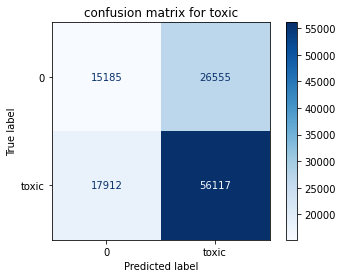

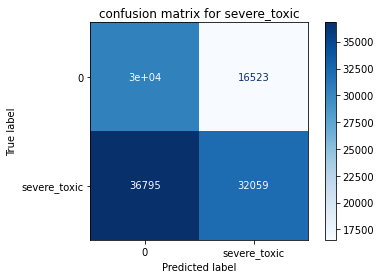

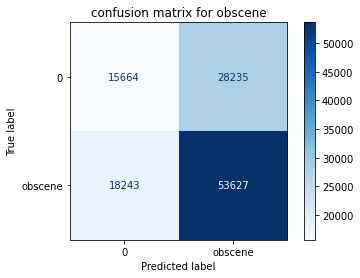

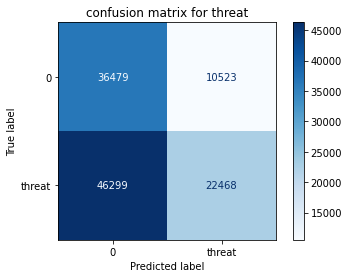

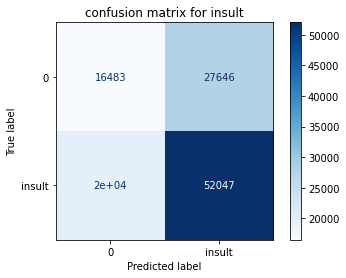

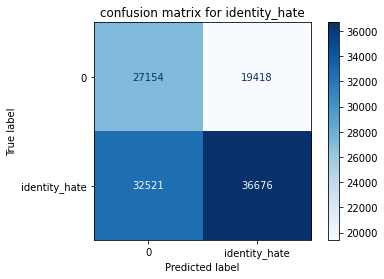

In [18]:
clf_pipeline_all_labels('Tfidf', 'RandomUnderSampler', 'VotingClassifier', True, True)

In [19]:
from lime.lime_text import LimeTextExplainer

def lime_explainer_output(vect_name, clf_name, label, idx, show_in_notebook_bool):
    try:
        select_label_cols = [col for col in list(train_df.columns) if col in ('comment_text',       label)]
        label_train_df = train_df[select_label_cols]
        label_test_df = test_df[select_label_cols]
        X_train, y_train = label_train_df.comment_text, label_train_df[label]
        X_test, y_test = label_test_df.comment_text, label_test_df[label]
        clf_pipeline = joblib.load(f'trained_models/{vect_name}/{clf_name}/{label}.pkl')
        explainer = LimeTextExplainer(class_names=[0, label])
        exp = explainer.explain_instance(X_test.iloc[idx], clf_pipeline.predict_proba, num_features=10)
        if show_in_notebook_bool:
            exp.as_pyplot_figure()
        else:
            exp.save_to_file(f'LIME_html/{vect_name}_{clf_name}_{label}.html')
    except:
        print(f'the {clf_name} model may not be suitable for LIME explanations')

In [20]:
# idx 85 is just an example of a comment_text that should be flagged
# keep in mind LogisticRegression is chosen here as it is the only classifier in the VotingClassifier that has predict_proba
lime_explainer_output('Tfidf', 'LogisticRegression', 'toxic', 85, False)

In [21]:
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain

multi_max_features = 3000
multi_vect_dict = {'Tfidf': TfidfVectorizer(stop_words=stop_words, max_features=multi_max_features)}
multi_transformer_dict = {'Tfidf': TfidfTransformer()}
multi_clf_dict = {
    'BinaryRelevance': BinaryRelevance(classifier = MultinomialNB()),
    'ClassifierChain': ClassifierChain(classifier = MultinomialNB())
    }

def clf_pipeline_multi(vect_name, clf_name, models_fitted_bool):
    multi_vectorizer = multi_vect_dict.get(vect_name, f'{vect_name} vectorizer not available')
    multi_transformer = multi_transformer_dict.get(vect_name, f'{vect_name} transformer not available')
    multi_clf_model = multi_clf_dict.get(clf_name, f'{clf_name} clf model not available')
    clf_pipeline = Pipeline([ 
    ('vect', multi_vectorizer),
    ('transform', multi_transformer),
    # to increase performance implemenation of multilabel sampling needed since imblearn sampling strategy does not work with skmultilearn
    # possible multilabel sampler would be multi_imbalance library however after some tries the imblearn pipeline does not work well
    ('clf', multi_clf_model)])
    multi_train_cols = ['comment_text'] + label_cols
    label_train_df = train_df[multi_train_cols]
    label_test_df = test_df[multi_train_cols]
    X_train, y_train = label_train_df.comment_text, label_train_df[label_cols].values
    X_test, y_test = label_test_df.comment_text, label_test_df[label_cols].values
    if models_fitted_bool:
        clf_pipeline = joblib.load(f'trained_models/{vect_name}/{clf_name}/skmultilearn.pkl')
    else:
        clf_pipeline.fit(X_train, y_train)
        joblib.dump(clf_pipeline, f'trained_models/{vect_name}/{clf_name}/skmultilearn.pkl')
    clf_preds = clf_pipeline.predict(X_test)
    clf_f1_scores = f1_score(y_test, clf_preds, average=None, pos_label=1)
    for i in range(len(label_cols)):
        print(f'{clf_name} with MultinomialNB base estimator f1_score for {label_cols[i]} comments: {clf_f1_scores[i]}\n')

In [22]:
%%time
# BinaryRelevance does not take into account interdependence of labels
clf_pipeline_multi('Tfidf', 'BinaryRelevance', True)

BinaryRelevance with MultinomialNB base estimator f1_score for toxic comments: 0.3592998192941586

BinaryRelevance with MultinomialNB base estimator f1_score for severe_toxic comments: 0.013000864802536755

BinaryRelevance with MultinomialNB base estimator f1_score for obscene comments: 0.23045972091430528

BinaryRelevance with MultinomialNB base estimator f1_score for threat comments: 0.0

BinaryRelevance with MultinomialNB base estimator f1_score for insult comments: 0.18789400979530327

BinaryRelevance with MultinomialNB base estimator f1_score for identity_hate comments: 0.005561879511822596

Wall time: 1min 9s


In [23]:
%%time
# ClassifierChain takes label relations into account
clf_pipeline_multi('Tfidf', 'ClassifierChain', True)

ClassifierChain with MultinomialNB base estimator f1_score for toxic comments: 0.3592998192941586

ClassifierChain with MultinomialNB base estimator f1_score for severe_toxic comments: 0.06588163071685688

ClassifierChain with MultinomialNB base estimator f1_score for obscene comments: 0.3467787929279939

ClassifierChain with MultinomialNB base estimator f1_score for threat comments: 0.008505098719895856

ClassifierChain with MultinomialNB base estimator f1_score for insult comments: 0.3420993632858039

ClassifierChain with MultinomialNB base estimator f1_score for identity_hate comments: 0.2646437487996927

Wall time: 1min 10s
